# Example usage of `discovery` with the parallel-tempering MCMC sampler `PTMCMC`

In [39]:
%load_ext autoreload
%autoreload 2
import json, glob, os, re
from jax.tree_util import Partial
import numpy as np

import discovery as ds

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from discovery import models
from discovery.samplers import ptmcmc_wrapper as dsampler

### Read in pulsar data in the form of feather files. Use the NANOGrav 15-year dataset packaged with `discovery`

In [10]:
datadir = '../data/'

# Find all .feather files in the directory
feather_files = sorted(glob.glob(os.path.join(datadir, 'v1p1*.feather')))
# Sort the files
feather_files.sort()

# Loop through the sorted list of .feather files and load each one
psrs = []
for file in feather_files:
    psrs.append(ds.Pulsar.read_feather(file))

with open('/Users/taylosr8/Research/repos/disco_tests/v1p1_wn_dict.json', 'r') as fp:
    wn_params = json.load(fp)

### Set up a `discovery` model the verbose way

Basic `CURN` or `HD` analysis
- fixed spectral index of 13/3
- intrinsic red noise is power-law with 30 components
- curn has 14 components
- fixed white noise

In [11]:
tspan = ds.getspan(psrs)

gamma_common = 13.0/3.0
red_components = 30
common_components = 14
common_type = 'curn'

In [13]:
if gamma_common is not None:
    common_powerlaw = Partial(ds.powerlaw, gamma=gamma_common)
    gamma_common_name = []
else:
    common_powerlaw = ds.powerlaw
    gamma_common_name = ['gw_gamma']

if common_type == 'curn':
    gl = ds.GlobalLikelihood((ds.PulsarLikelihood([psr.residuals,
                                ds.makenoise_measurement(psr, wn_params), # EFAC, EQUAD white noise
                                ds.makegp_ecorr(psr, wn_params), # ECORR
                                ds.makegp_timing(psr, svd=True), # timing model
                                ds.makegp_fourier(psr, ds.powerlaw, red_components, T=tspan, name='red_noise'), # intrinsic red noise
                                ds.makegp_fourier(psr, common_powerlaw, common_components, T=tspan,
                                                    common=['gw_log10_A']+gamma_common_name, name='gw') # common red noise
                                                    ]) for psr in psrs))
elif common_type == 'hd':
        gl = ds.GlobalLikelihood((ds.PulsarLikelihood([psr.residuals,
                                    ds.makenoise_measurement(psr, wn_params),  # EFAC, EQUAD white noise
                                    ds.makegp_ecorr(psr, wn_params), # ECORR
                                    ds.makegp_timing(psr, svd=True), # timing model
                                    ds.makegp_fourier(psr, ds.powerlaw, red_components, T=tspan, name="red_noise") # intrinsic red noise
                                    ]) for psr in psrs),
                                    ds.makegp_fourier_global(psrs, common_powerlaw,
                                                             ds.hd_orf, common_components,
                                                             T=tspan, name="gw")) # gwb

The easier way is to use the `models` module to make your likelihood object with keyword arguments.

In [16]:
# curn model with varied gamma
model_curn_vg = models.lhood_maker(psrs, wn_params, gamma_common=None,
                                   common_components=14, red_components=30, common_type='curn')
# curn model with fixed gamma
model_curn_fg = models.lhood_maker(psrs, wn_params, gamma_common=13.0/3.0,
                                   common_components=14, red_components=30, common_type='curn')
# hd model with varied gamma
model_hd_vg = models.lhood_maker(psrs, wn_params, gamma_common=None,
                                   common_components=14, red_components=30, common_type='hd')
# hd model with fixed gamma
model_hd_fg = models.lhood_maker(psrs, wn_params, gamma_common=13.0/3.0,
                                   common_components=14, red_components=30, common_type='hd')

In [17]:
# Parameter names
model_curn_fg.logL.params

['B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'B1937+21_red_noise_gamma',
 'B1937+21_red_noise_log10_A',
 'B1953+29_red_noise_gamma',
 'B1953+29_red_noise_log10_A',
 'J0023+0923_red_noise_gamma',
 'J0023+0923_red_noise_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'J0340+4130_red_noise_gamma',
 'J0340+4130_red_noise_log10_A',
 'J0406+3039_red_noise_gamma',
 'J0406+3039_red_noise_log10_A',
 'J0437-4715_red_noise_gamma',
 'J0437-4715_red_noise_log10_A',
 'J0509+0856_red_noise_gamma',
 'J0509+0856_red_noise_log10_A',
 'J0557+1551_red_noise_gamma',
 'J0557+1551_red_noise_log10_A',
 'J0605+3757_red_noise_gamma',
 'J0605+3757_red_noise_log10_A',
 'J0610-2100_red_noise_gamma',
 'J0610-2100_red_noise_log10_A',
 'J0613-0200_red_noise_gamma',
 'J0613-0200_red_noise_log10_A',
 'J0636+5128_red_noise_gamma',
 'J0636+5128_red_noise_log10_A',
 'J0645+5158_red_noise_gamma',
 'J0645+5158_red_noise_log10_A',
 'J0709+0458_red_noise_gamma',
 'J0709+0458_red_nois

Let's test the log-likelihood function at some random position in a uniform prior space.

In [18]:
random_vec = ds.prior.sample_uniform(model_curn_fg.logL.params)

In [19]:
print(model_curn_fg.logL(random_vec))

8191107.167421723


Time the likelihood while we're at it.

In [23]:
%%timeit
model_curn_fg.logL(random_vec)

12.3 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can probably make this faster by jit compiling the log-likelihood function.

In [21]:
import jax
jlogl = jax.jit(model_curn_fg.logL)

In [24]:
%%timeit
jlogl(random_vec)

1.66 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


10 times faster for me!

### Prepare the model for `PTMCMC`

Pass the `discovery` model to the sampler's `InferenceModel` class along with pulsar names. By default it will `jit` compile the log-likelihood and a log-uniform prior.

In [25]:
disco_infmodel_curn_fg = dsampler.InferenceModel(model_curn_fg, pnames=[p.name for p in psrs])

Time it again to see the interface for the new `get_lnlikelihood` function. Note that there is an intermediate function pass that converts a parameter dictionary to an array, which is what the log-likelihood function of `PTMCMC` expects.

In [27]:
%%timeit
disco_infmodel_curn_fg.get_lnlikelihood(disco_infmodel_curn_fg.p2x(random_vec))

1.62 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Setup the sampler

- Provide an initial position, the parameter dimensionality, and instantiate the sampler object. 
- This will also automatically find `groups` of parameters that are most covariant, e.g., intrinsic red noise power-law parameters, and the power-law parameters of a common process. 
- Prior draws will also be added into the proposal cycle for intrinsic red noise and the common process.

In [28]:
# Initial position of the sampler
initial_position = ds.prior.sample_uniform(disco_infmodel_curn_fg.param_names)
# Number of parameters
ndim = len(initial_position)

sampler = disco_infmodel_curn_fg.setup_sampler(outdir='./example_chain_output/curn_fg/', resume=False)

Adding red noise prior draws...

Adding GWB uniform distribution draws...



The following takes less than 3 minutes on a Macbook M3 Pro

In [29]:
# Number of samples
n_samples = int(1e5)

# Run the sampler
samples = sampler.sample(disco_infmodel_curn_fg.p2x(initial_position), n_samples)

Finished 10.00 percent in 17.186681 s Acceptance rate = 0.49019Adding DE jump with weight 20
Finished 100.00 percent in 161.611604 s Acceptance rate = 0.46567
Run Complete


Load in the chain

In [32]:
chain = np.loadtxt('./example_chain_output/curn_fg/chain_1.txt')
chain = dict(zip(disco_infmodel_curn_fg.param_names, chain[:,:-4].T))

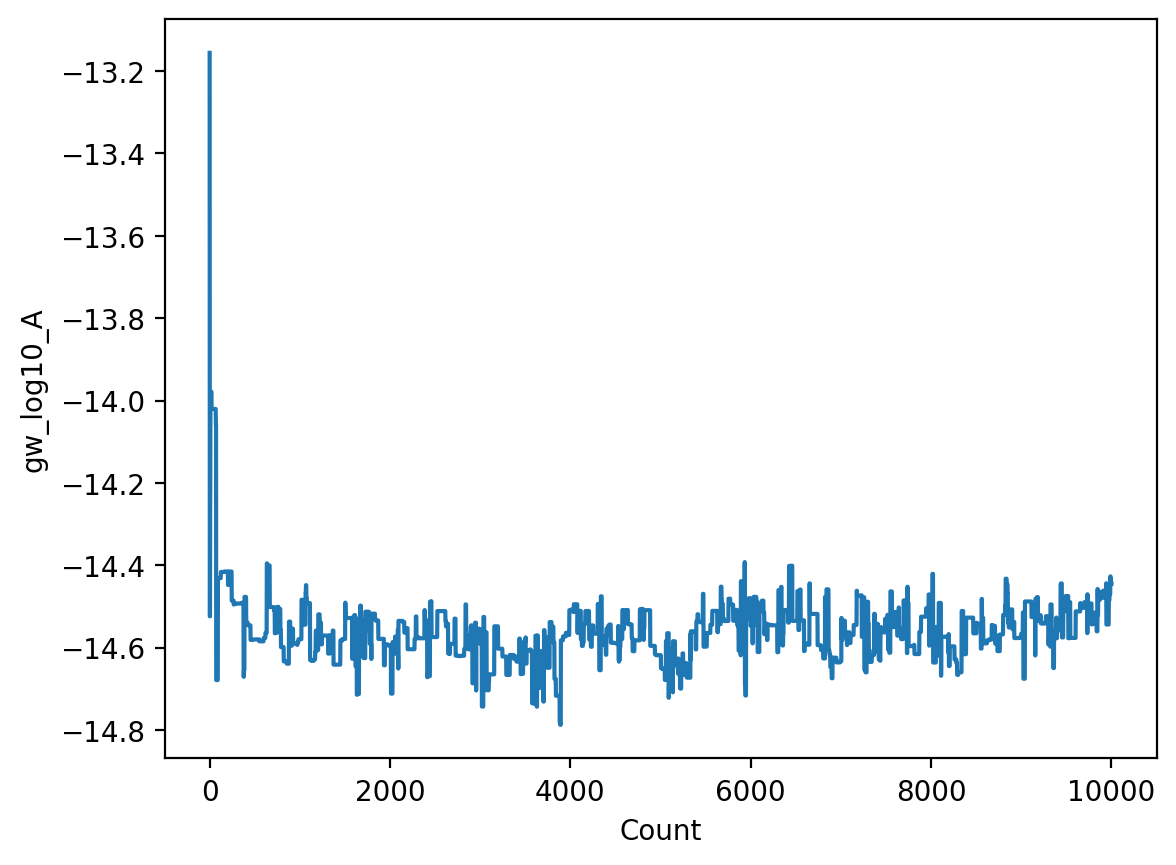

In [37]:
plt.plot(chain['gw_log10_A'][0:]);
plt.xlabel('Count')
plt.ylabel('gw_log10_A')
plt.show()

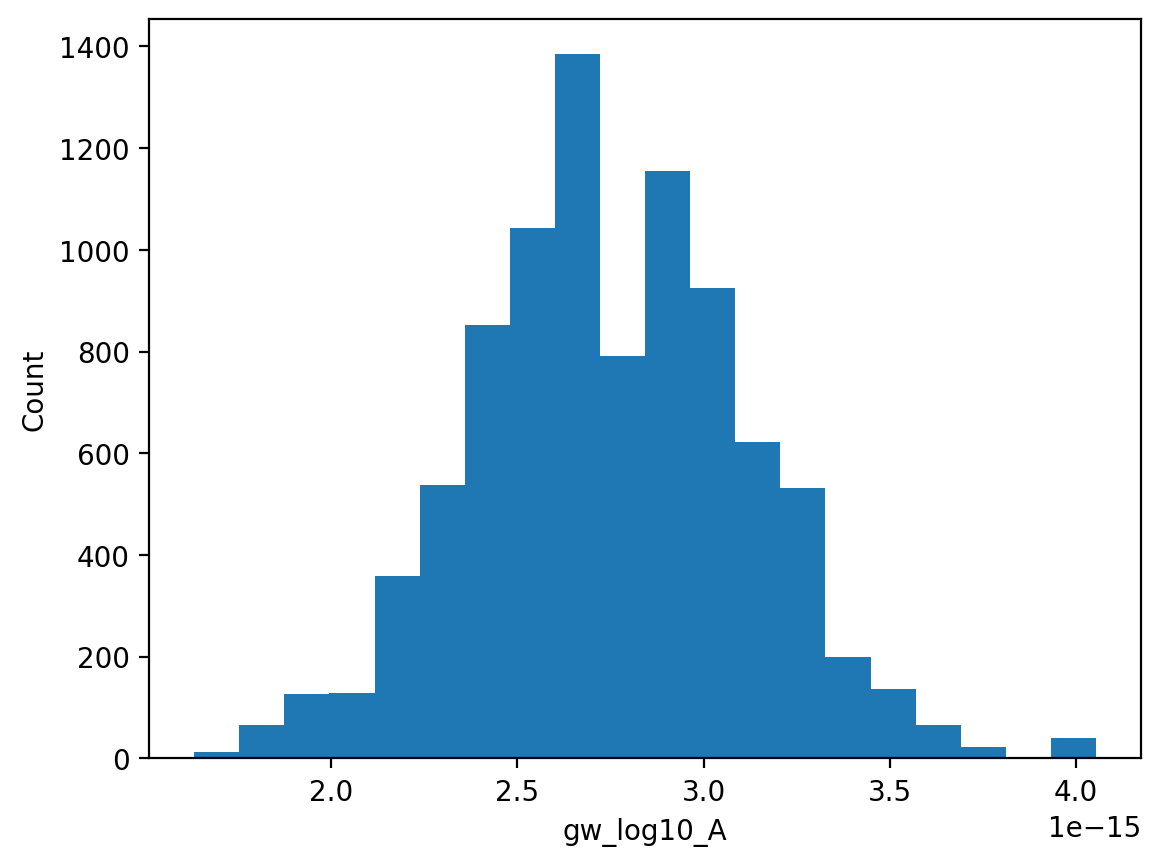

In [38]:
burn = 1000
plt.hist(10**chain['gw_log10_A'][burn:],bins=20);
plt.ylabel('Count')
plt.xlabel('gw_log10_A')
plt.show()